Permasalahan yang diangkat pada projek kali ini  terkait data Indeks Harga Saham Gabungan (dalam Bahasa Inggris disebut juga Jakarta Composite Index, JCI, atau JSX Composite) yang merupakan salah satu indeks pasar saham yang digunakan oleh Bursa Efek Indonesia (BEI) dari periode 1 Juli 2018- 1 Juli 2021. Data awal yang digunakan berupa data IHSG dan terdiri dari 7 atribut, berkisar 751 record awal. Data IHSG ini mencakup waktu pembukaan, waktu penutupan, harga tertinggi, harga terendah, harga penutupan, harga penyesuaian, dan volume. Pada tahapan selanjutnya perlu dilakukan transformasi atribut dan cleaning data agar dapat digunakan pada tahapan selanjutnya.

Analisis data yang coba dilakukan meliputi :
-	Prediksi pergerakan harga saham, apakah saham akan naik atau turun
-	Klasifikasi pergerakan harga saham

Penting memahami kepentingan bisnis dan memahami data agar dapat mendefinisikan tujuan yang hendak dicapai. Oleh karena itu, dengan menggunakan data IHSG ini dapat ditemukan keterkaitan hubungan antar atribut di atas.
Harapannya, hasil dari analisis atau pengetahuan tersebut dapat digunakan untuk menggambarkan karakteristik dari saham IHSG dan membantu para investor untuk dapat mengambil keputusan.


In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import talib as tlb
import talib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras import layers

### 1. Data Preprocessing

Kode berikut ini berfungsi untuk membaca dataset dari file CSV. Dataset yang dibaca yaitu berisi data IHSG (Jakarta Composite Index (^JKSE)) selama 5 tahun terakhir periode Juli 2018 - Juli 2021.

In [ ]:
# Import Data
dataset = pd.read_csv("D:/Data Saham.csv")
dataset

Setelah data diinput, langkah awal yang perlu dilakukan adalah membaca dataset. Kita dapat  menggunakan fungsi yang disediakan oleh Pandas yaitu read_csv(). Kemudian, untuk mengetahui ringkasan statistik secara singkat dapat dilakukan sebagai berikut :

In [ ]:
# Deskripsi Statistik
dataset.describe()

Pada bagian ini kita akan memvisualisasikan Data Frame yang berisi data IHSG dengan melakukan plotting menggunakan Plotly. Kita perlu membuat sebuah fungsi untuk melakukan plotting sebagai berikut:

In [ ]:
# Bangun Fungsi untuk Visualisasi
def Grafik(dataset, title):
    fig = px.line(title=title)
    for i in dataset.columns[1:-1]:
        fig.add_scatter(x=dataset['Date'], y=dataset[i], name=i)
    fig.show()

Pada baris pertama, fungsi tersebut memiliki dua input argument yaitu DataFrame yang akan kita plot (dataset) dan judul plot yang akan digunakan (title). Kita dapat melakukan plotting dengan memanggil fungsi tersebut seperti pada kode berikut ini:


In [ ]:
# Visualisasi
Grafik(dataset, 'Prices')

### Data Cleansing

Salah satu langkah penting pada data preprocessing yaitu menghandle missing values. Selain dengan visualisasi, kita juga dapat melakukan pengecekan missing values dengan kode berikut ini: 

In [ ]:
from jcopml.plot import plot_missing_value
plot_missing_value(dataset, return_df=True)

Ada beberapa cara untuk men-handle missing values, seperti membuang data tersebut, mengisi missing values tersebut dengan mean, median, atau interpolasi. Di sini saya memilih untuk membuang data  tersebut, dengan kode berikut :

In [ ]:
dataset = dataset.dropna(axis='rows')
dataset

In [ ]:
plot_missing_value(dataset, return_df=True)

In [3]:
# Import Data
start = dt.datetime(2018,7,1)
finish = dt.datetime(2021,7,1)
source = 'yahoo'

In [4]:
df = web.DataReader('UNVR.JK', source, start, finish)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-07-02,9190.0,9040.0,9180.0,9070.0,5207500.0,8368.929688
2018-07-03,9040.0,8810.0,9000.0,8935.0,6845500.0,8244.365234
2018-07-04,9300.0,8825.0,8965.0,9295.0,5389500.0,8576.537109
2018-07-05,9340.0,9090.0,9240.0,9250.0,4884000.0,8535.016602
2018-07-06,9280.0,9080.0,9230.0,9150.0,6534500.0,8442.746094


Saya akan menggunakan data 'Adj Close' sebagai target prediksi. Sejauh ini, memprediksi harga saham dengan tepat dari hari ke hari, sulit untuk dilakukan dengan pembelajaran mesin, jadi apa yang akan kami prediksi  adalah pergerakan saham, apakah saham akan turun atau naik. Untuk melakukan ini saya akan menghitung persentase perubahan harga saham hari ini dari kemarin dan seterusnya, dan jika positif, akan ditandai +1.0 dan sebaliknya.

In [5]:
data = pd.DataFrame(index=df.index)
data['Today'] = df['Adj Close']
data['pct change'] = data['Today'].pct_change()
data['direction'] = np.sign(data['pct change'])

Selanjutnya, akan dilakukan beberapa rekayasa fitur menggunakan menggunakan package talib, dan menormalisasi hasilnya sehingga berada dalam kisaran yang sama dengan membagi hasilnya dengan harga Penutupan

In [6]:
for n in [5,10,20,35,55]:
    
    #Creating the moving average indicator and divide by Adj close
    data['ma'+str(n)] = tlb.SMA(data['Today'].values, timeperiod = n)/data['Today']
    
    #Create RSI Indicator
    data['rsi'+str(n)] = tlb.RSI(data['Today'].values/data['Today'],timeperiod = n)

Kode di atas pada dasarnya adalah untuk mencari Simple Moving Average dan Relative Strength Index setiap  5, 10, 20, 35, dan 55 hari. Hasilnya sebagai berikut :

In [7]:
data.head()

,Today,pct change,direction,ma5,rsi5,ma10,rsi10,ma20,rsi20,ma35,rsi35,ma55,rsi55
Date,,,,,,,,,,,,,
2018-07-02,8368.929688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,8244.365234,-0.014884,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-04,8576.537109,0.040291,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-05,8535.016602,-0.004841,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-06,8442.746094,-0.010811,-1.0,0.998907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data yang dihasilkan ternyata terdapat banyak data yang hilang.Karena machine learning tidak dapat mengolah jika masih terdapat data yang hilang, maka data tersebut harus dibuang dengan kode berikut:

In [ ]:
data.dropna(inplace = True)

Selanjutnya kolom ‘Today’ dan ‘pct change' akan dihapus karena saya hanya memprediksi arah pergerakan saham sehingga kedua variabel ini tidak dibutuhkan.

In [10]:
data.drop(['Today', 'pct change'], axis = 1, inplace = True)

### 3. Splitting data

Sebelum melakukan split data, data perlu dibagi menjadi X (feature) dan y (target) seperti berikut :

In [11]:
X = data.drop('direction', axis = 1)
y = data['direction']

In [53]:
X

,ma5,rsi5,ma10,rsi10,ma20,rsi20,ma35,rsi35,ma55,rsi55
Date,,,,,,,,,,
2018-09-17,1.004777,0.0,0.975027,0.0,0.960586,0.0,0.950644,0.0,0.963962,0.0
2018-09-18,1.016365,0.0,0.989676,0.0,0.974876,0.0,0.963034,0.0,0.975418,0.0
2018-09-19,1.001840,0.0,0.985173,0.0,0.964529,0.0,0.949876,0.0,0.961059,0.0
2018-09-20,0.993029,0.0,0.985952,0.0,0.959249,0.0,0.942244,0.0,0.952445,0.0
2018-09-21,0.983431,0.0,0.982050,0.0,0.954408,0.0,0.934527,0.0,0.943852,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-25,1.004000,0.0,1.014000,0.0,1.060362,0.0,1.082299,0.0,1.136004,0.0
2021-06-28,0.996020,0.0,1.004478,0.0,1.048646,0.0,1.072536,0.0,1.125522,0.0
2021-06-29,0.999000,0.0,1.006000,0.0,1.046429,0.0,1.074197,0.0,1.126205,0.0


Langkah selanjutnya adalah melakukan splitting data menjadi train set dan test set.Rasio yang digunakan adalah 70% train set dan 30% test set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 33)

### 4. Build Model using Random Forest Classifier

Saya akan menggunakan 2 algoritma machine learning untuk melihat mana yang berkinerja lebih baik. Yaitu, Random Forest Classifier dan Random Forest Classifier dengan Adaboost Algorithm

Pertama, import package yang dibutuhkan untuk membangun model.

Langkah selanjutnya, membangun model Random Forest dengan mengimport Random Forest Classifier, kemudian memprediksi pergerakan harga saham apakah akan naik/turun (+1 artinya naik, -1 artinya turun, dan 0 artinya tidak ada kenaikan/penurunan).

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

#### Predict and print classification report

Kemudian, untuk menentukan apakah prediksi tersebut bisa dipercaya atau tidak, kita perlu mengecek tingkat akurasi dari prediksi yang sudah dilakukan. Langkahnya sebagai berikut :

In [15]:
y_pred = rf.predict(X_test)
y_pred

array([-1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
       -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1., -1.,  0., -1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  0.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1., -1.,  0.,  1.,  1., -1.,  1., -1.,  1.,  1.,
       -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
        1.,  0.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1.,  0., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1

In [16]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.67      0.76      0.71        97
         0.0       0.20      0.04      0.07        23
         1.0       0.62      0.66      0.64        90

    accuracy                           0.64       210
   macro avg       0.50      0.49      0.47       210
weighted avg       0.60      0.64      0.61       210



#### Confusion matrix

In [17]:
cmr = confusion_matrix(y_test,y_pred)
cmr

array([[74,  1, 22],
       [ 8,  1, 14],
       [28,  3, 59]], dtype=int64)

#### Visualization

Text(0.5, 1.0, 'Confusion Matrix for IHSG Dataset using Random Forest')

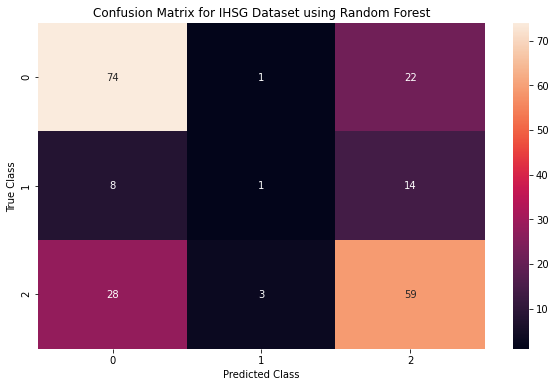

In [18]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cmr, annot = True)

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix for IHSG Dataset using Random Forest")

Tingkat akurasi yang diperoleh dari prediksi menggunakan Random Forest Classifier adalah sebesar 64%. Selanjutnya, saya akan membandingkannya jika algoritma Random Forest dilakukan boosting dengan Adaboost Algorithm. Apakah akan ada peningkatan atau tidak?

### 5. Random Forest using Adaboost Algorithm

In [19]:
np.random.seed (123)

# Create adaboost classifier object
adaaboost = AdaBoostClassifier(n_estimators = 50, base_estimator = rf,learning_rate = 1)

# Train Adaboost Classifer
model = adaaboost.fit(X_train, y_train)

#Predict the response for test dataset
y_rf_pred = model.predict(X_test)

In [20]:
y_rf_pred

array([-1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
       -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1., -1.,  0., -1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  0.,  1., -1.,
        1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1., -1., -1.,  1., -1.,  0.,  1.,  1., -1.,  1., -1.,  1.,  1.,
       -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
        1.,  0.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
        1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1., -1., -1., -1.,  0., -1., -1.,  1.,  0.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1

#### Predict and print classification report

In [21]:
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

        -1.0       0.67      0.77      0.72        97
         0.0       0.33      0.09      0.14        23
         1.0       0.65      0.67      0.66        90

    accuracy                           0.65       210
   macro avg       0.55      0.51      0.50       210
weighted avg       0.63      0.65      0.63       210



#### Confusion matrix

In [22]:
cmbr = confusion_matrix(y_test,y_rf_pred)
cmbr

array([[75,  1, 21],
       [10,  2, 11],
       [27,  3, 60]], dtype=int64)

#### Visualization

Text(0.5, 1.0, 'Confusion Matrix for IHSG Dataset after Boosting')

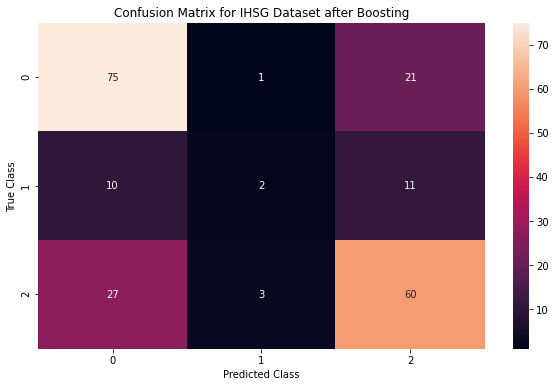

In [23]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cmbr, annot = True)

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix for IHSG Dataset after Boosting")

Ternyata, tingkat akurasi yang diperoleh setelah dilakukan boosting mengalami peningkatan. Meskipun peningkatan akurasi nya tidak terlalu signifikan, dapat disimpulkan bahwa pada case data IHSG, Random Forest Classifier dengan Adaboost Algorithm kinerjanya lebih baik dibandingkan Random Forest Classifier.

### 6. Artificial Neural Network

Analisis selanjutnya adalah dengan mengklasifikasikan perkembangan harga saham menggunakan metode Artificial Neural Network.

Karena data input yang digunakan sama dengan sebelumnya, maka pada tahap ini dimulai dari pelabelan data

In [27]:
from urllib.request import urlretrieve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from keras.wrappers.scikit_learn import KerasClassifier

Encode label pada data dengan menggunakan metode One Hot Encoding

In [28]:
encoder = LabelEncoder()

In [29]:
categorical_data = ["direction"]

In [30]:
for kolom in categorical_data:
    data[kolom] = encoder.fit_transform(data[kolom])

In [32]:
label = pd.get_dummies(data['direction'])
label.columns = ['direction_' + str(x) for x in label.columns]

In [33]:
data= pd.concat([data, label], axis = 1)
data.head(25)

,direction,ma5,rsi5,ma10,rsi10,ma20,rsi20,ma35,rsi35,ma55,rsi55,direction_0,direction_1,direction_2
Date,,,,,,,,,,,,,,
2018-09-17,0,1.004777,0.0,0.975027,0.0,0.960586,0.0,0.950644,0.0,0.963962,0.0,1,0,0
2018-09-18,0,1.016365,0.0,0.989676,0.0,0.974876,0.0,0.963034,0.0,0.975418,0.0,1,0,0
2018-09-19,2,1.001840,0.0,0.985173,0.0,0.964529,0.0,0.949876,0.0,0.961059,0.0,0,0,1
2018-09-20,2,0.993029,0.0,0.985952,0.0,0.959249,0.0,0.942244,0.0,0.952445,0.0,0,0,1
2018-09-21,2,0.983431,0.0,0.982050,0.0,0.954408,0.0,0.934527,0.0,0.943852,0.0,0,0,1
2018-09-24,1,0.987785,0.0,0.985342,0.0,0.957993,0.0,0.935953,0.0,0.944112,0.0,0,1,0
2018-09-25,0,1.012935,0.0,1.009402,0.0,0.982364,0.0,0.959348,0.0,0.965731,0.0,1,0,0
2018-09-26,2,1.010743,0.0,1.007651,0.0,0.982528,0.0,0.959693,0.0,0.963587,0.0,0,0,1
2018-09-27,2,0.989926,0.0,0.985949,0.0,0.963150,0.0,0.940327,0.0,0.941714,0.0,0,0,1


In [34]:
encoder = LabelEncoder()
categorical_data = ["direction"]
for kolom in categorical_data:
    data[kolom] = encoder.fit_transform(data[kolom])

In [35]:
data.head(25)

,direction,ma5,rsi5,ma10,rsi10,ma20,rsi20,ma35,rsi35,ma55,rsi55,direction_0,direction_1,direction_2
Date,,,,,,,,,,,,,,
2018-09-17,0,1.004777,0.0,0.975027,0.0,0.960586,0.0,0.950644,0.0,0.963962,0.0,1,0,0
2018-09-18,0,1.016365,0.0,0.989676,0.0,0.974876,0.0,0.963034,0.0,0.975418,0.0,1,0,0
2018-09-19,2,1.001840,0.0,0.985173,0.0,0.964529,0.0,0.949876,0.0,0.961059,0.0,0,0,1
2018-09-20,2,0.993029,0.0,0.985952,0.0,0.959249,0.0,0.942244,0.0,0.952445,0.0,0,0,1
2018-09-21,2,0.983431,0.0,0.982050,0.0,0.954408,0.0,0.934527,0.0,0.943852,0.0,0,0,1
2018-09-24,1,0.987785,0.0,0.985342,0.0,0.957993,0.0,0.935953,0.0,0.944112,0.0,0,1,0
2018-09-25,0,1.012935,0.0,1.009402,0.0,0.982364,0.0,0.959348,0.0,0.965731,0.0,1,0,0
2018-09-26,2,1.010743,0.0,1.007651,0.0,0.982528,0.0,0.959693,0.0,0.963587,0.0,0,0,1
2018-09-27,2,0.989926,0.0,0.985949,0.0,0.963150,0.0,0.940327,0.0,0.941714,0.0,0,0,1


Bagi data menjadi feature dan label atau X dan Y, kemudian split menjadi data training dan data testing dengan menggunakan rasio 70% data training dan 30% data testing.

In [36]:
X = data.iloc[:, 0:11].values
Y = data.iloc[:, 11:14].values

In [37]:
X = np.asarray(X)
Y = np.asarray(Y)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 33)

Standardisasi data

In [39]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
print(f'X_train: {X_train.shape}')

X_train: (487, 11)


In [41]:
print(f'X_test: {X_test.shape}')

X_test: (210, 11)


In [42]:
print(f'Y_train: {Y_train.shape}')

Y_train: (487, 3)


In [43]:
print(f'Y_test: {Y_test.shape}')

Y_test: (210, 3)


#### Build Model

Bangun model menggunakan model sequential dan menampilkan summary dari model yang telah dibangun

In [48]:
model = Sequential()
model.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
model.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 12        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


In [50]:
model1 = model.fit(X_train,Y_train, epochs=100,batch_size = 5,validation_data=(X_test,Y_test))

Epoch 1/100
98/98 [==============================] - 0s 2ms/step - loss: 0.6207 - accuracy: 0.4949 - val_loss: 0.5977 - val_accuracy: 0.6238
Epoch 2/100
98/98 [==============================] - 0s 878us/step - loss: 0.5431 - accuracy: 0.8337 - val_loss: 0.4972 - val_accuracy: 0.8381
Epoch 3/100
98/98 [==============================] - 0s 857us/step - loss: 0.4291 - accuracy: 0.8604 - val_loss: 0.3917 - val_accuracy: 0.8619
Epoch 4/100
98/98 [==============================] - 0s 817us/step - loss: 0.3264 - accuracy: 0.8891 - val_loss: 0.3081 - val_accuracy: 0.8762
Epoch 5/100
98/98 [==============================] - 0s 854us/step - loss: 0.2493 - accuracy: 0.9076 - val_loss: 0.2523 - val_accuracy: 0.8857
Epoch 6/100
98/98 [==============================] - 0s 831us/step - loss: 0.1996 - accuracy: 0.9179 - val_loss: 0.2159 - val_accuracy: 0.8857
Epoch 7/100
98/98 [==============================] - 0s 847us/step - loss: 0.1692 - accuracy: 0.9199 - val_loss: 0.1929 - val_accuracy: 0.8857
E

Epoch 58/100
98/98 [==============================] - 0s 848us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 59/100
98/98 [==============================] - 0s 817us/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 60/100
98/98 [==============================] - 0s 806us/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 61/100
98/98 [==============================] - 0s 817us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 62/100
98/98 [==============================] - 0s 833us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 63/100
98/98 [==============================] - 0s 822us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 64/100
98/98 [==============================] - 0s 827us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy:

In [51]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Akurasi Testing ANN:', accuracy)

7/7 [==============================] - 0s 1ms/step - loss: 2.0352e-04 - accuracy: 1.0000
Akurasi Testing ANN: 1.0


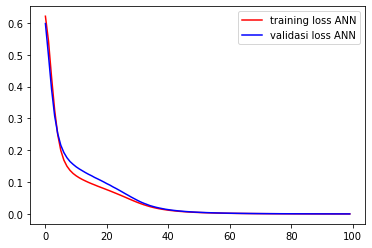

In [52]:
epochs = range(100)

loss = model1.history['loss']
val_loss = model1.history['val_loss']

plt.plot(epochs,loss,'r',label='training loss ANN')
plt.plot(epochs,val_loss,'b',label='validasi loss ANN')
plt.legend()

In [53]:
predict = model.predict(X_test)
print(classification_report(Y_test.argmax(axis=1), predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        90

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



In [54]:
cm = confusion_matrix(Y_test.argmax(axis=1), predict.argmax(axis=1))
cm

array([[97,  0,  0],
       [ 0, 23,  0],
       [ 0,  0, 90]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix for IHSG Dataset using ANN')

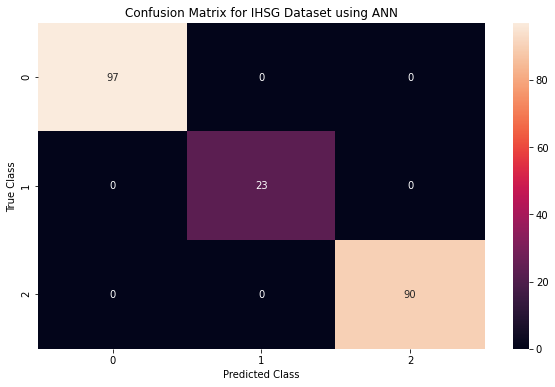

In [55]:
#Plotting confusion matrix

fig = plt.figure(figsize = (10, 6))
sns.heatmap(cm, annot = True)

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix for IHSG Dataset using ANN")

Kesimpulan : Berdasarkan model yang telah dibangun, nilai akurasi yang diperoleh adalah 1. Hal ini menunjukan model yang dibangun sangat baik. Tidak ada kesalahan dalam melakukan prediksi dan klasifikasi. Di sisi lain, hasil ini mengindikasikan bahwa model ANN unggul dibandingkan model machine learning tradisional seperti Random Forest.